In [113]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import numpy as np
import datetime
import glob
import cv2
import os

### Our data

##### Load data

In [146]:
dates = ['24032019', '17042019', '01052019']
labels = ['yafim', 'zeev', 'or', 'ron', 'sergey', 'aviya', 'elnatan', 'felix']

In [176]:
x_data = []
y_data = []

In [178]:
def prep_data(dates, labels, x_data, y_data):
    for d in dates:
        for i, l in enumerate(labels):
            for f in tqdm(glob.glob('../data/frames/{0}/{1}/32/*.png'.format(d, l))):
                x_data.append(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
                y_data.append(i)                
    
    x_data = np.asarray(x_data)
    y_data = np.asarray(y_data)
    
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)
    x_train, x_test = x_train / 255.0, x_test / 255.0
    return x_train, x_test, y_train, y_test

In [174]:
def show_sample(idx):
    plt.imshow(x_data[idx])
    plt.show()

In [33]:
unique, counts = np.unique(y_test, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1217],
       [   1, 5007],
       [   2, 6636],
       [   3, 6658],
       [   4, 1153],
       [   5, 5896],
       [   6,  633]])

In [53]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32)),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
])

In [59]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [60]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 3591      
Total params: 528,391
Trainable params: 528,391
Non-trainable params: 0
_________________________________________________________________


In [69]:
def set_curr_time():
    dt = datetime.datetime.now()
    curr_dt = '{0}{1}{2}_{3}_{4}'.format(datetime.datetime.now().year, datetime.datetime.now().month,
                                       datetime.datetime.now().day, datetime.datetime.now().hour,
                                      datetime.datetime.now().minute)
    return curr_dt

In [57]:
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/{0}'.format(curr_dt), histogram_freq=0, write_graph=True, write_images=True)

In [58]:
model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256, epochs=50, callbacks=[tb_callback])

ValueError: You are passing a target array of shape (108800, 1) while using as loss `categorical_crossentropy`. `categorical_crossentropy` expects targets to be binary matrices (1s and 0s) of shape (samples, classes). If your targets are integer classes, you can convert them to the expected format via:
```
from keras.utils import to_categorical
y_binary = to_categorical(y_int)
```

Alternatively, you can use the loss function `sparse_categorical_crossentropy` instead, which does expect integer targets.

In [62]:
model.evaluate(x_test, y_test)

27200/27200 [==============================] - 1s 45us/sample - loss: 2.1906 - acc: 0.0249


[2.1906236864538755, 0.02492647]

In [126]:
conf_list = [
    [32, 512, 0.2],
    [32, 256, 0.2],
    [32, 512, 0.1],
]

In [189]:
def custom_model(config, model_weights=None):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(conf[0], conf[0])),
        tf.keras.layers.Dense(conf[1], activation=tf.nn.relu),
        tf.keras.layers.Dropout(conf[2]),
        tf.keras.layers.Dense(len(labels), activation=tf.nn.softmax)
    ])
    if model_weights is not None:
        print('loading pre-trained model')
        model.load_weights(model_weights, by_name=True)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [187]:
def run_custom_training(conf_list, x_train, y_train, x_test, y_test, model_path_prefix=None, model_weights=None):
    for conf in conf_list:
        curr_dt = set_curr_time()
        tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/{0}_{1}'.format(conf, curr_dt),
                                                     histogram_freq=0, write_graph=True)
        model = custom_model(conf, model_weights)
        model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256,
                  epochs=50, callbacks=[tb_callback])
        model.evaluate(x_test, y_test)
        if model_path_prefix is None:
            model.save('../models/{0}_{1}.h5'.format(conf, curr_dt))
        else:
            model.save('../models/{0}_{1}_{2}.h5'.format(model_path_prefix, conf, curr_dt))

##### continues training

In [79]:
c_model = tf.keras.models.load_model('../models/[32, 512, 0.1]_201953_12_56.h5')

In [80]:
c_model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256,
              epochs=50, callbacks=[tb_callback])

Train on 108800 samples, validate on 27200 samples
Epoch 1/50
108800/108800 [==============================] - 4s 38us/sample - loss: 0.9533 - acc: 0.5728 - val_loss: 0.8804 - val_acc: 0.6037
Epoch 2/50
108800/108800 [==============================] - 4s 35us/sample - loss: 0.8633 - acc: 0.6125 - val_loss: 0.8448 - val_acc: 0.6270
Epoch 3/50
108800/108800 [==============================] - 4s 35us/sample - loss: 0.8428 - acc: 0.6237 - val_loss: 0.8382 - val_acc: 0.6372
Epoch 4/50
108800/108800 [==============================] - 4s 36us/sample - loss: 0.8259 - acc: 0.6343 - val_loss: 0.8250 - val_acc: 0.6406
Epoch 5/50
108800/108800 [==============================] - 4s 36us/sample - loss: 0.8123 - acc: 0.6428 - val_loss: 0.8121 - val_acc: 0.6474
Epoch 6/50
108800/108800 [==============================] - 4s 36us/sample - loss: 0.8077 - acc: 0.6449 - val_loss: 0.8207 - val_acc: 0.6395
Epoch 7/50
108800/108800 [==============================] - 4s 36us/sample - loss: 0.7951 - acc: 0.6513

In [81]:
c_model.evaluate(x_test, y_test)

27200/27200 [==============================] - 1s 46us/sample - loss: 0.7825 - acc: 0.6661


[0.7825135770615409, 0.66610295]

In [84]:
for model_path in glob.glob('../models/*.h5'):
    print(model_path)
    best_loaded = tf.keras.models.load_model(model_path)
    best_loaded.evaluate(x_test, y_test)

../models/[32, 512, 0.2]_201953_12_51.h5
27200/27200 [==============================] - 1s 54us/sample - loss: 0.7060 - acc: 0.7012
../models/[32, 256, 0.2]_201953_12_54.h5
27200/27200 [==============================] - 1s 44us/sample - loss: 0.7264 - acc: 0.6867
../models/[32, 512, 0.1]_201953_12_56.h5
27200/27200 [==============================] - 2s 59us/sample - loss: 0.6649 - acc: 0.7292
../models/[32, 512, 0.2]_201953_12_46.h5
27200/27200 [==============================] - 2s 61us/sample - loss: 0.7218 - acc: 0.6947


In [85]:
best_loaded = tf.keras.models.load_model('../models/[32, 512, 0.1]_201953_12_56.h5')
test_predictions = best_loaded.predict(x_test)

In [87]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, np.argmax(test_predictions,axis=1))
confusion

array([[1217,    0,    0,    0,    0,    0,    0],
       [   0, 3174,  309,  879,    0,  645,    0],
       [   0,  177, 5386,  443,    0,  630,    0],
       [   0,  569,  666, 4133,    0, 1290,    0],
       [   0,    0,    0,    0, 1153,    0,    0],
       [   0,  289,  546,  924,    0, 4137,    0],
       [   0,    0,    0,    0,    0,    0,  633]])

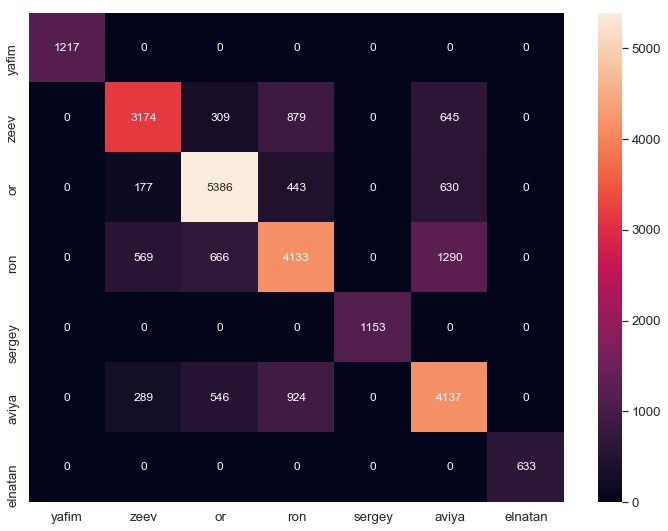

In [104]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(confusion, labels, labels)
plt.figure(figsize = (12, 9))
sn.set(font_scale=1.2)
sn.heatmap(df_cm, annot=True, fmt='.5g', annot_kws={"size": 12})

In [105]:
df_cm

,yafim,zeev,or,ron,sergey,aviya,elnatan
yafim,1217,0,0,0,0,0,0
zeev,0,3174,309,879,0,645,0
or,0,177,5386,443,0,630,0
ron,0,569,666,4133,0,1290,0
sergey,0,0,0,0,1153,0,0
aviya,0,289,546,924,0,4137,0
elnatan,0,0,0,0,0,0,633


### devided images (biased)

In [132]:
x_data = []
y_data = []

In [133]:
for d in dates:
    for l_idx, l in enumerate(labels):
        f_path = '../data/frames/{0}/{1}/32'.format(d, l)
        if os.path.exists(f_path):
            f_list = os.listdir(f_path)
            for i in tqdm(range(0, len(f_list) - 1)):
                img1 = cv2.imread('{0}/{1}'.format(f_path, f_list[i]), cv2.IMREAD_GRAYSCALE)
                img2 = cv2.imread('{0}/{1}'.format(f_path, f_list[i+1]), cv2.IMREAD_GRAYSCALE)
                img = img1 - img2
                x_data.append(img)
                y_data.append(l_idx)

100%|██████████| 2999/2999 [00:00<00:00, 4497.99it/s]


In [134]:
x_data = np.asarray(x_data)
y_data = np.asarray(y_data)

In [135]:
x_data.shape

(135988, 32, 32)

In [136]:
y_data

array([0, 0, 0, ..., 6, 6, 6])

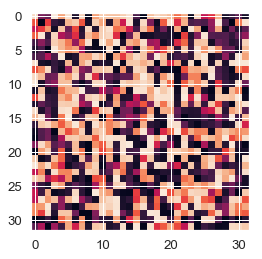

In [137]:
plt.imshow(x_data[0])
plt.show()

In [138]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

In [139]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [140]:
x_train.shape

(108790, 32, 32)

In [141]:
unique, counts = np.unique(y_test, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 1154],
       [   1, 5030],
       [   2, 6678],
       [   3, 6583],
       [   4, 1201],
       [   5, 5958],
       [   6,  594]])

In [142]:
for conf in conf_list:
    curr_dt = set_curr_time()
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs/sub_imgs_{0}_{1}'.format(conf, curr_dt),
                                                 histogram_freq=0, write_graph=True)
    model = custom_model(conf)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=256,
              epochs=50, callbacks=[tb_callback])
    model.evaluate(x_test, y_test)
    model.save('../models/sub_imgs_{0}_{1}.h5'.format(conf, curr_dt))

Train on 108790 samples, validate on 27198 samples
Epoch 1/50
108790/108790 [==============================] - 4s 41us/sample - loss: 1.4098 - acc: 0.3781 - val_loss: 1.1859 - val_acc: 0.4530
Epoch 2/50
108790/108790 [==============================] - 4s 36us/sample - loss: 1.1648 - acc: 0.4623 - val_loss: 1.1280 - val_acc: 0.4711
Epoch 3/50
108790/108790 [==============================] - 4s 35us/sample - loss: 1.1079 - acc: 0.4849 - val_loss: 1.0926 - val_acc: 0.4780
Epoch 4/50
108790/108790 [==============================] - 4s 36us/sample - loss: 1.0711 - acc: 0.5026 - val_loss: 1.0672 - val_acc: 0.4867
Epoch 5/50
108790/108790 [==============================] - 4s 36us/sample - loss: 1.0442 - acc: 0.5141 - val_loss: 1.0690 - val_acc: 0.4903
Epoch 6/50
108790/108790 [==============================] - 4s 39us/sample - loss: 1.0201 - acc: 0.5257 - val_loss: 1.0343 - val_acc: 0.5121
Epoch 7/50
108790/108790 [==============================] - 4s 40us/sample - loss: 1.0010 - acc: 0.5354

108790/108790 [==============================] - 3s 24us/sample - loss: 1.0329 - acc: 0.5167 - val_loss: 1.0484 - val_acc: 0.5039
Epoch 8/50
108790/108790 [==============================] - 3s 24us/sample - loss: 1.0178 - acc: 0.5261 - val_loss: 1.0305 - val_acc: 0.5113
Epoch 9/50
108790/108790 [==============================] - 3s 24us/sample - loss: 1.0030 - acc: 0.5341 - val_loss: 1.0285 - val_acc: 0.5132
Epoch 10/50
108790/108790 [==============================] - 3s 24us/sample - loss: 0.9913 - acc: 0.5408 - val_loss: 1.0175 - val_acc: 0.5185
Epoch 11/50
108790/108790 [==============================] - 3s 24us/sample - loss: 0.9784 - acc: 0.5486 - val_loss: 1.0133 - val_acc: 0.5224
Epoch 12/50
108790/108790 [==============================] - 3s 24us/sample - loss: 0.9702 - acc: 0.5506 - val_loss: 1.0162 - val_acc: 0.5192
Epoch 13/50
108790/108790 [==============================] - 3s 24us/sample - loss: 0.9618 - acc: 0.5551 - val_loss: 1.0433 - val_acc: 0.5149
Epoch 14/50
108790/1

Epoch 14/50
108790/108790 [==============================] - 4s 37us/sample - loss: 0.9057 - acc: 0.5916 - val_loss: 0.9906 - val_acc: 0.5365
Epoch 15/50
108790/108790 [==============================] - 4s 36us/sample - loss: 0.8939 - acc: 0.5973 - val_loss: 0.9861 - val_acc: 0.5416
Epoch 16/50
108790/108790 [==============================] - 4s 37us/sample - loss: 0.8843 - acc: 0.6024 - val_loss: 1.0064 - val_acc: 0.5358
Epoch 17/50
108790/108790 [==============================] - 4s 37us/sample - loss: 0.8681 - acc: 0.6127 - val_loss: 1.0112 - val_acc: 0.5396
Epoch 18/50
108790/108790 [==============================] - 4s 37us/sample - loss: 0.8554 - acc: 0.6199 - val_loss: 1.0154 - val_acc: 0.5383
Epoch 19/50
108790/108790 [==============================] - 4s 36us/sample - loss: 0.8462 - acc: 0.6258 - val_loss: 1.0060 - val_acc: 0.5402
Epoch 20/50
108790/108790 [==============================] - 4s 36us/sample - loss: 0.8299 - acc: 0.6334 - val_loss: 1.0203 - val_acc: 0.5348
Epoch 

### 5 labels (a lot of data for each)

In [179]:
labels = ['zeev', 'or', 'ron', 'aviya', 'felix']

In [180]:
x_train, x_test, y_train, y_test = prep_data(dates, labels, x_data, y_data)

100%|██████████| 3000/3000 [00:00<00:00, 9925.23it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 30000/30000 [00:03<00:00, 9501.30it/s]
0it [00:00, ?it/s]
100%|██████████| 22000/22000 [00:02<00:00, 9229.77it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


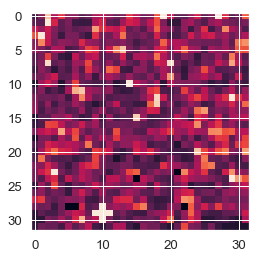

In [182]:
show_sample(1)

In [190]:
run_custom_training(conf_list, x_train, y_train, x_test, y_test,
                    model_path_prefix='5_lbls', model_weights='../models/[32, 512, 0.1]_201953_12_56.h5')

loading pre-trained model
Train on 96800 samples, validate on 24200 samples
Epoch 1/50
96800/96800 [==============================] - 4s 44us/sample - loss: 1.1835 - acc: 0.4488 - val_loss: 1.1399 - val_acc: 0.4496
Epoch 2/50
96800/96800 [==============================] - 4s 40us/sample - loss: 1.0609 - acc: 0.5205 - val_loss: 1.0094 - val_acc: 0.5531
Epoch 3/50
96800/96800 [==============================] - 4s 39us/sample - loss: 1.0169 - acc: 0.5474 - val_loss: 1.0608 - val_acc: 0.5215
Epoch 4/50
96800/96800 [==============================] - 4s 39us/sample - loss: 0.9935 - acc: 0.5612 - val_loss: 0.9959 - val_acc: 0.5554
Epoch 5/50
96800/96800 [==============================] - 4s 40us/sample - loss: 0.9825 - acc: 0.5666 - val_loss: 0.9728 - val_acc: 0.5700
Epoch 6/50
96800/96800 [==============================] - 4s 41us/sample - loss: 0.9606 - acc: 0.5784 - val_loss: 0.9787 - val_acc: 0.5681
Epoch 7/50
96800/96800 [==============================] - 4s 40us/sample - loss: 0.9480 - 

Epoch 8/50
96800/96800 [==============================] - 4s 40us/sample - loss: 0.9455 - acc: 0.5859 - val_loss: 0.9778 - val_acc: 0.5714
Epoch 9/50
96800/96800 [==============================] - 4s 40us/sample - loss: 0.9320 - acc: 0.5938 - val_loss: 0.9341 - val_acc: 0.5873
Epoch 10/50
96800/96800 [==============================] - 4s 39us/sample - loss: 0.9228 - acc: 0.5985 - val_loss: 0.9556 - val_acc: 0.5812
Epoch 11/50
96800/96800 [==============================] - 4s 39us/sample - loss: 0.9063 - acc: 0.6063 - val_loss: 0.9754 - val_acc: 0.5719
Epoch 12/50
96800/96800 [==============================] - 4s 39us/sample - loss: 0.8990 - acc: 0.6103 - val_loss: 0.9156 - val_acc: 0.6045
Epoch 13/50
96800/96800 [==============================] - 4s 40us/sample - loss: 0.8905 - acc: 0.6150 - val_loss: 0.9047 - val_acc: 0.6060
Epoch 14/50
96800/96800 [==============================] - 4s 39us/sample - loss: 0.8792 - acc: 0.6216 - val_loss: 0.9030 - val_acc: 0.6060
Epoch 15/50
96800/9680

96800/96800 [==============================] - 4s 39us/sample - loss: 0.8764 - acc: 0.6216 - val_loss: 0.9079 - val_acc: 0.6008
Epoch 16/50
96800/96800 [==============================] - 4s 39us/sample - loss: 0.8672 - acc: 0.6249 - val_loss: 0.8884 - val_acc: 0.6108
Epoch 17/50
96800/96800 [==============================] - 4s 39us/sample - loss: 0.8576 - acc: 0.6314 - val_loss: 0.9420 - val_acc: 0.5873
Epoch 18/50
96800/96800 [==============================] - 4s 39us/sample - loss: 0.8501 - acc: 0.6373 - val_loss: 0.9003 - val_acc: 0.6107
Epoch 19/50
96800/96800 [==============================] - 4s 39us/sample - loss: 0.8424 - acc: 0.6399 - val_loss: 0.8890 - val_acc: 0.6151
Epoch 20/50
96800/96800 [==============================] - 4s 39us/sample - loss: 0.8368 - acc: 0.6440 - val_loss: 0.8747 - val_acc: 0.6210
Epoch 21/50
96800/96800 [==============================] - 4s 39us/sample - loss: 0.8271 - acc: 0.6496 - val_loss: 0.8548 - val_acc: 0.6366
Epoch 22/50
96800/96800 [=======